In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, glob
from scipy.stats import linregress, norm, spearmanr

from bqplot import (
    LogScale, LinearScale, ColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip, Toolbar )
import bqplot.pyplot as bqplt
import bqplot.marks as bqm
from IPython.display import display
from ipywidgets import Dropdown, HBox, VBox

plt.style.use('ggplot')

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#This uses data from AnAge, a curated database of animal specifications, part of the Human Ageing Genomic Resources

raw_data = pd.read_csv('data/anage_data.txt', sep="\t")
genome = pd.read_csv('data/genomes.txt', sep='\t', encoding='latin-1')
GO_data = pd.read_csv('data/animalsGO.txt', sep='\t')

#Remove species with missing data
data = raw_data[np.isfinite(raw_data['Body mass (g)'])]

#Add column for whether animal has had its genome sequenced
data['Binomial'] = data['Genus'] + ' ' + data['Species']
data = pd.merge(data, genome, how="outer", on='Binomial')
data['Genome'] = data['Genome'].fillna(value=0)

data = pd.merge(data, GO_data, how="outer", on='Common name')
data.drop(['Unnamed: 0'], 1)

data = data[np.isfinite(data['Maximum longevity (yrs)'])]
data = data[np.isfinite(data['Metabolic rate (W)'])]
# data = data[np.isfinite(data['Temperature (K)'])]

# data['Temperature (C)'] = data['Temperature (K)'] - 273.15
data['Lifetime expenditure of energy (W/yrs/g)'] = data['Metabolic rate (W)']/data['Maximum longevity (yrs)']/data['Body mass (g)']

data = data.reset_index()

In [3]:
mammals_and_birds = data[(data['Class']!='Reptilia') & (data['Class']!='Amphibia')]
repts_and_amphibs = data[(data['Class']=='Reptilia') | (data['Class']=='Amphibia')]
mammals = data[data['Class'] == 'Mammalia']

birds = data[data['Class'] == 'Aves']

In [4]:
rodents = data[data['Order']=='Rodentia']
carnivores = data[data['Order']=='Carnivora']
bats = data[data['Order']=='Chiroptera']
primates = data[data['Order']=='Primates']

# Lifespan vs. Body Mass

### Raw Data

Text(0.5, 1.0, 'Species Body Mass vs. Lifespan')

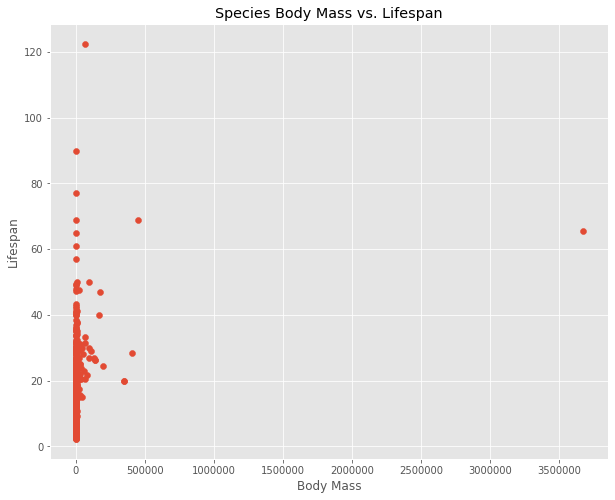

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(data['Body mass (g)'], data['Maximum longevity (yrs)'])
#plt.xlim(xmin=-2000,xmax=100000)
plt.xlabel('Body Mass')
plt.ylabel('Lifespan')
plt.title('Species Body Mass vs. Lifespan')

### Log Standardized Data

In [7]:
BM_min, BM_max = np.min(data['Body mass (g)'].apply(np.min)), np.max(data['Body mass (g)'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['Maximum longevity (yrs)'].apply(np.min)), np.max(data['Maximum longevity (yrs)'].apply(np.max))

x_sc = LogScale(min=BM_min, max=BM_max)
y_sc = LogScale(min=lifespan_min, max=lifespan_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', 'Body Mass (g)', 'Max Lifespan (yrs)'])

fig_scat = Scatter(x=data['Body mass (g)'], y=data['Maximum longevity (yrs)'], 
                      names=data['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=60, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_y = Axis(label='Max Lifespan (yrs)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Body Mass (g)', scale=x_sc, grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Does Body Mass Affect Maximum Lifespan Across Animal Species?')

box = VBox([fig])

display(box)

In [8]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['Body mass (g)']), np.log(data['Maximum longevity (yrs)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and Lifespan: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and Lifespan: (0.12305958292088484, 0.16141539110338374)
The r^2 value for the relationship is 0.2790353972064184.
The associated p-value is 1.044233019192078e-40.


### Effect of Temperature on Lifespan for Similarly Sized Species

In [9]:
temp_data = data[(data['Body mass (g)'] >= 20) & (data['Body mass (g)'] <= 30)]
temp_data['1/Temperature (1/K)'] = 1/temp_data['Temperature (K)']

lifespan_min, lifespan_max = np.min(temp_data['Maximum longevity (yrs)'].apply(np.min)), np.max(temp_data['Maximum longevity (yrs)'].apply(np.max))
temp_min, temp_max = np.min(temp_data['1/Temperature (1/K)'].apply(np.min)), np.max(temp_data['1/Temperature (1/K)'].apply(np.max))

x_sc = LinearScale(min=temp_min, max=temp_max)
y_sc = LogScale(min=lifespan_min, max=lifespan_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', '1/Temperature (1/K)', 'Max Lifespan (yrs)'])

fig_scat = Scatter(x=temp_data['1/Temperature (1/K)'], y=temp_data['Maximum longevity (yrs)'],
                      names=temp_data['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='1/Temperature (1/K)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Max Lifespan (yrs)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Does an Inverse Relationship Exist Between Temp. and Lifespan?')

fig

Figure(axes=[Axis(label='1/Temperature (1/K)', scale=LinearScale(max=0.003472222222222222, min=0.0031831927423…

# Association Between Body Mass and BMR

#### Note: the asiatic elephant is an influential point

### Raw Data

Text(0.5, 1.0, 'Species Metabolic Rate vs. Body Mass')

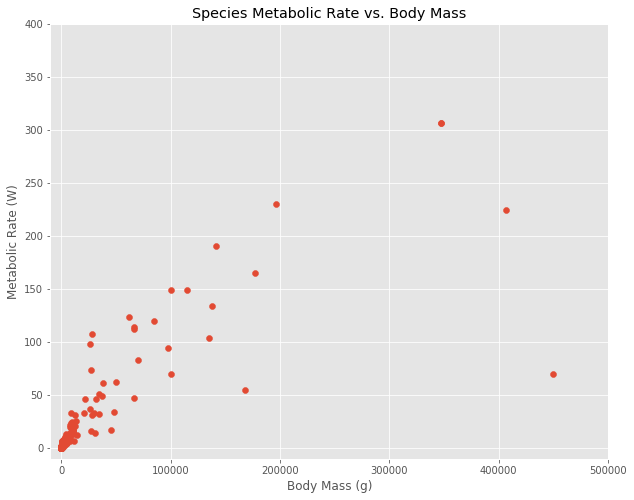

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(mammals_and_birds['Body mass (g)'], mammals_and_birds['Metabolic rate (W)'])
plt.xlim(xmin=-10000,xmax=500000)
plt.ylim(ymin=-10,ymax=400)
plt.xlabel('Body Mass (g)')
plt.ylabel('Metabolic Rate (W)')
plt.title('Species Metabolic Rate vs. Body Mass')

In [11]:
x_min, x_max = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['Metabolic rate (W)']/mammals_and_birds[mammals_and_birds['Genome']==1]['Body mass (g)'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['Metabolic rate (W)']/mammals_and_birds[mammals_and_birds['Genome']==1]['Body mass (g)'].apply(np.max))
y_min, y_max = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['Maximum longevity (yrs)'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['Maximum longevity (yrs)'].apply(np.max))
size_min, size_max = np.min(mammals_and_birds[mammals_and_birds['Genome']==1]['Protein_Coding'].apply(np.min)), np.max(mammals_and_birds[mammals_and_birds['Genome']==1]['Protein_Coding'].apply(np.max))

x_sc = LogScale(min=x_min, max=x_max)
y_sc = LogScale(min=y_min, max=y_max)
size_sc = LinearScale(min=size_min, max=size_max)

tt = Tooltip(fields=['name', 'x', 'y', 'size'], 
             labels=['Animal', 'BMR / M', 'Lifespan', '# Protein Coding'])

fig_scat = Scatter(x=mammals_and_birds[mammals_and_birds['Genome']==1]['Metabolic rate (W)']/mammals_and_birds[mammals_and_birds['Genome']==1]['Body mass (g)'].round(decimals = 3), 
                   y=mammals_and_birds[mammals_and_birds['Genome']==1]['Maximum longevity (yrs)'].round(decimals=1), 
                   size=mammals_and_birds[mammals_and_birds['Genome']==1]['Protein_Coding'],
                      names=mammals_and_birds[mammals_and_birds['Genome']==1]['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'size': size_sc},
                      default_size=300, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='BMR / M', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Lifespan', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y], 
             title='Lifespan Compared to BMR / M (Size = # of Protein Coding Genes)')
fig.layout.height = '750px'
fig.layout.width = '1000px'

display(fig)
fig.save_png()

Figure(axes=[Axis(label='BMR / M', scale=LogScale(max=0.041428571428571426, min=0.0007714814814814815)), Axis(…

In [12]:
alpha, intercept, r_value, p_value, std_err = linregress(np.log(mammals_and_birds['Metabolic rate (W)']/mammals_and_birds['Body mass (g)']), np.log(mammals_and_birds['Maximum longevity (yrs)']))
low_bound = alpha - 1.96 * std_err
high_bound = alpha + 1.96 * std_err

print('95% CI for power relationship between BMR/M and lifespan: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')


95% CI for power relationship between BMR/M and lifespan: (-0.39834482208387445, -0.28373270311567766)
The r^2 value for the relationship is 0.20865724426359927.
The associated p-value is 4.577613539559144e-28.


# Graphical Analysis of Significant GO Terms

In [13]:
data['NL (-alpha)'] = data['Maximum longevity (yrs)'] / (data['Metabolic rate (W)']/data['Body mass (g)']) ** (alpha)
data['NL (-1)'] = data['Maximum longevity (yrs)'] / (data['Metabolic rate (W)']/data['Body mass (g)']) ** (-1)
mammals_and_birds = data[(data['Class']!='Reptilia') & (data['Class']!='Amphibia')]

genned_data = data[data['Genome']==1]
#genned_data = genned_data[np.isfinite(genned_data['Total'])]
genned_data = genned_data.drop_duplicates(subset=['Common name'], keep="first")
genned_data = genned_data.reset_index(drop=True)
genned_data = genned_data.reindex([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,4,1,2,0,3,24])
genned_data = genned_data.drop([44,45])


In [14]:
genned_data.sort_values(by=['NL (-1)'], ascending=False)

,index,HAGRID,Kingdom,Phylum,Class,Order,Family,Genus,Species,Common name,...,Temperature (K),References,Binomial,Genome,Unnamed: 0,Total,Protein_Coding,Lifetime expenditure of energy (W/yrs/g),NL (-alpha),NL (-1)
5,115,779.0,Animalia,Chordata,Aves,Passeriformes,Fringillidae,Serinus,canaria,House canary,...,314.15,"1,62,403,405,425,820",Serinus canaria,1.0,16.0,17380.0,15225.0,0.000721,6.015899,0.415155
14,297,2048.0,Animalia,Chordata,Mammalia,Chiroptera,Vespertilionidae,Myotis,lucifugus,Little brown bat,...,305.15,"36,74,178,295,424,428,434,441,455,477,731,777,...",Myotis lucifugus,1.0,115.0,25849.0,19728.0,0.000259,6.766307,0.298966
6,175,1262.0,Animalia,Chordata,Aves,Psittaciformes,Psittacidae,Melopsittacus,undulatus,Budgerigar,...,314.15,"62,403,405,425,444,600,000",Melopsittacus undulatus,1.0,17.0,16945.0,14568.0,0.000574,4.652468,0.252917
4,104,745.0,Animalia,Chordata,Aves,Passeriformes,Estrildidae,Lonchura,striata,White-rumped munia,...,NaN,"2,425,732,820",Lonchura striata,1.0,99.0,18255.0,15917.0,0.002091,2.674117,0.209107
3,101,739.0,Animalia,Chordata,Aves,Passeriformes,Emberizidae,Zonotrichia,albicollis,White-throated sparrow,...,NaN,"61,427,435,444,445,700",Zonotrichia albicollis,1.0,96.0,18252.0,13862.0,0.000924,3.454686,0.205059
2,93,719.0,Animalia,Chordata,Aves,Passeriformes,Emberizidae,Junco,hyemalis,Dark-eyed junco,...,NaN,"435,444,445,818,911",Junco hyemalis,1.0,88.0,17477.0,14551.0,0.001455,2.783696,0.185759
28,423,2424.0,Animalia,Chordata,Mammalia,Primates,Hominidae,Homo,sapiens,Human,...,310.15,"2,13,14,29,30,31,36,58,59,65,75,76,110,111,121...",Homo sapiens,1.0,213.0,66832.0,22722.0,0.000010,12.298631,0.144865
43,602,2855.0,Animalia,Chordata,Mammalia,Soricomorpha,Soricidae,Sorex,araneus,Eurasian shrew,...,308.15,"36,420,434,455,504,500,000,000,000,000",Sorex araneus,1.0,329.0,19134.0,13187.0,0.012946,1.080428,0.132571
7,189,1542.0,Animalia,Chordata,Mammalia,Afrosoricida,Tenrecidae,Echinops,telfairi,Lesser hedgehog tenrec,...,307.85,"3,614,843,445,554,260,000,000,000,000,000,000,000",Echinops telfairi,1.0,18.0,26079.0,16575.0,0.000339,3.400749,0.122423
0,27,263.0,Animalia,Chordata,Aves,Anseriformes,Anatidae,Anas,platyrhynchos,Mallard,...,NaN,"61,394,437,444,445,500,000,000",Anas platyrhynchos,1.0,25.0,25952.0,16616.0,0.000137,4.422484,0.116058


In [15]:
sigGOTerms_pos = pd.read_csv('data/sigGOTerms_pos.txt', sep='\t')
sigGOTerms_neg = pd.read_csv('data/sigGOTerms_neg.txt', sep='\t')

In [16]:
pos_GO_opts = sigGOTerms_pos['GO ID'].values
neg_GO_opts = sigGOTerms_neg['GO ID'].values
life_opts = ['Maximum longevity (yrs)', 'NL (-1)', 'NL (-alpha)']

dataPath = r'/Users/alexyu/Downloads/kaks/countData/count_'
for term in pos_GO_opts:
    f_term = term[3:]
    
    try:
        genned_data['GO:'+f_term] = pd.read_csv(dataPath + f_term + '.txt', sep='\t', header=None).values[:-2]
    except:
        print('Error: File contains a wrong number of terms. Term skipped.')
        
for term in neg_GO_opts:
    f_term = term[3:]
    
    try:
        genned_data['GO:'+f_term] = pd.read_csv(dataPath + f_term + '.txt', sep='\t', header=None).values[:-2]
    except:
        print('Error: File contains a wrong number of terms. Term skipped.')

## Term Proportion vs. Longevity

In [17]:
# Create two dropdown menus for X and Y attributes of scatter
default_x = pos_GO_opts[0]
default_y = life_opts[0]
x_dropdown = Dropdown(description = 'GO Term:', options = pos_GO_opts, value = default_x)
y_dropdown = Dropdown(description = 'Lifespan Measure:', options = life_opts, value = default_y)

# Find min and max x and y values for axes scale
x_min, x_max = np.min(genned_data[default_x]/genned_data['Protein_Coding'].apply(np.min)), np.max(genned_data[default_x]/genned_data['Protein_Coding'].apply(np.max))
y_min, y_max = 0, np.max(genned_data[default_y].apply(np.max))
x_sc = LinearScale(min = x_min, max = x_max)
y_sc = LinearScale(min = y_min, max = y_max)

# Set up axes
ax_x = Axis(label = 'Proportion of %s Genes' % default_x, scale = x_sc, grid_lines = 'solid')
ax_y = Axis(label = default_y, scale = y_sc, orientation = 'vertical', side = 'left', grid_lines = 'solid')

# Create tooltip for hover action
tt = Tooltip(fields =  ['name', 'x', 'y'], 
             labels = ['Animal', ax_x.label, default_y])

# Create scatter plot of data
fig_scat = Scatter(x = genned_data[default_x]/genned_data['Protein_Coding'].round(decimals = 3), 
                   y = genned_data[default_y].round(decimals=1), names = genned_data['Common name'], 
                   display_names = False, scales = {'x': x_sc, 'y': y_sc, 'size': size_sc}, default_size = 50, 
                   tooltip = tt, animate = True, stroke = 'Black', unhovered_style = {'opacity': 0.5})

# Create figure
fig = Figure(animation_duration = 500, marks = [fig_scat], axes = [ax_x, ax_y], 
             title = 'Normalized Lifespan Compared to the Proportion of Certain Genes')
fig.layout.height = '600px'
fig.layout.width = '800px'

# 1. create a callback which updates the plot when dropdown item is selected
def update_scatter(*args):
    x_ticker = x_dropdown.value
    y_ticker = y_dropdown.value
    
    with fig_scat.hold_sync():
        fig_scat.x = genned_data[x_ticker]/genned_data['Protein_Coding'].round(decimals = 3)
        fig_scat.y = genned_data[y_ticker].round(decimals=1)
        
        x_sc.min, x_sc.max = np.min(genned_data[x_ticker]/genned_data['Protein_Coding'].apply(np.min)), np.max(genned_data[x_ticker]/genned_data['Protein_Coding'].apply(np.max))
        y_sc.min, y_sc.max = 0, np.max(genned_data[y_ticker].apply(np.max))
        
        ax_x.label = 'Proportion of %s Genes' % x_ticker
        ax_y.label = y_ticker
        
        tt.labels = ['Animal', ax_x.label, y_ticker]

# 2. register the callback by using the 'observe' method
x_dropdown.observe(update_scatter, 'value')
y_dropdown.observe(update_scatter, 'value')

VBox([HBox([x_dropdown, y_dropdown]), fig])


## BMR / M vs. Longevity, with Term Proportion as Size

In [18]:
# Create dropdown menu for size attributes of scatter
default = pos_GO_opts[0]
dropdown = Dropdown(description = 'GO Term:', options = pos_GO_opts, value = default)
np_dropdown = Dropdown(description = 'Correlation Type:', options = ['Positive', 'Negative'], value = 'Positive')

x_min, x_max = np.min(genned_data[genned_data['Genome']==1]['Metabolic rate (W)']/genned_data[genned_data['Genome']==1]['Body mass (g)'].apply(np.min)), np.max(genned_data[genned_data['Genome']==1]['Metabolic rate (W)']/genned_data[genned_data['Genome']==1]['Body mass (g)'].apply(np.max))
y_min, y_max = np.min(genned_data[genned_data['Genome']==1]['Maximum longevity (yrs)'].apply(np.min)), np.max(genned_data[genned_data['Genome']==1]['Maximum longevity (yrs)'].apply(np.max))
size_min, size_max = np.min(genned_data[genned_data['Genome']==1][default]/genned_data[genned_data['Genome']==1]['Protein_Coding'].apply(np.min)), np.max(genned_data[genned_data['Genome']==1][default]/genned_data[genned_data['Genome']==1]['Protein_Coding'].apply(np.max))

x_sc = LogScale(min=x_min, max=x_max)
y_sc = LogScale(min=y_min, max=y_max)
size_sc = LinearScale(min=size_min, max=size_max)

# Create tooltip for hover action
tt = Tooltip(fields =  ['name', 'x', 'y', 'size'], 
             labels = ['Animal', 'BMR / M', 'Max Lifespan', 'Term Prop'])


fig_scat = Scatter(x=genned_data[genned_data['Genome']==1]['Metabolic rate (W)']/genned_data[genned_data['Genome']==1]['Body mass (g)'].round(decimals = 3), 
                   y=genned_data[genned_data['Genome']==1]['Maximum longevity (yrs)'].round(decimals=1), 
                      size=genned_data[genned_data['Genome']==1][default]/genned_data[genned_data['Genome']==1]['Protein_Coding'],
                      names=genned_data[genned_data['Genome']==1]['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'size': size_sc},
                      default_size=500, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='BMR / M', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Lifespan', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(animation_duration = 500, marks=[fig_scat], axes=[ax_x, ax_y], 
             title='Lifespan Compared to BMR / M (Size = % of Term Proportion)')
fig.layout.height = '600px'
fig.layout.width = '800px'

# 1. create a callback which updates the plot when dropdown item is selected
def update_scatter(*args):
    ticker = dropdown.value
    
    with fig_scat.hold_sync():
        
        fig_scat.size = size=genned_data[genned_data['Genome']==1][ticker]/genned_data[genned_data['Genome']==1]['Protein_Coding']
        size_sc.min, size_sc.max = size_min, size_max = np.min(genned_data[genned_data['Genome']==1][ticker]/genned_data[genned_data['Genome']==1]['Protein_Coding'].apply(np.min)), np.max(genned_data[genned_data['Genome']==1][ticker]/genned_data[genned_data['Genome']==1]['Protein_Coding'].apply(np.max))
        
def update_dropdown(*args):
    np_ticker = np_dropdown.value
    
    with fig_scat.hold_sync():
        
        if np_ticker == 'Positive':
            dropdown.options = pos_GO_opts
            dropdown.value = pos_GO_opts[0]
        else:
            dropdown.options = neg_GO_opts
            dropdown.value = neg_GO_opts[0]
            
    update_scatter()
        
# 2. register the callback by using the 'observe' method
dropdown.observe(update_scatter, 'value')
np_dropdown.observe(update_dropdown, 'value')

VBox([HBox([np_dropdown, dropdown]), fig])

In [471]:
sigGOTerms_pos

,GO ID,GO Definition
0,GO:0008484,sulfuric ester hydrolase activity
1,GO:0015074,DNA integration
2,GO:0006546,glycine catabolic process
3,GO:0004719,protein-L-isoaspartate (D-aspartate) O-methylt...
4,GO:0090657,telomeric loop disassembly
5,GO:0061608,nuclear import signal receptor activity
6,GO:0034594,phosphatidylinositol trisphosphate phosphatase...
7,GO:0086007,voltage-gated calcium channel activity involve...
8,GO:0061820,telomeric D-loop disassembly
9,GO:0034450,ubiquitin-ubiquitin ligase activity


### Log Standardized Data

In [254]:
BM_min, BM_max = np.min(data['Body mass (g)'].apply(np.min)), np.max(data['Body mass (g)'].apply(np.max))
BMR_min, BMR_max = np.min(data['Metabolic rate (W)'].apply(np.min)), np.max(data['Metabolic rate (W)'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['Maximum longevity (yrs)'].apply(np.min)), np.max(data['Maximum longevity (yrs)'].apply(np.max))

x_sc = LogScale(min=BM_min, max=BM_max)
y_sc = LogScale(min=BMR_min, max=BMR_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', 'Body Mass (g)', 'Metabolic Rate (W)'])

fig_scat1 = Scatter(x=mammals_and_birds['Body mass (g)'], y=mammals_and_birds['Metabolic rate (W)'].round(decimals = 3), colors=['blue'],
                      names=mammals_and_birds['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

fig_scat2 = Scatter(x=repts_and_amphibs['Body mass (g)'], y=repts_and_amphibs['Metabolic rate (W)'].round(decimals = 3), colors=['orange'],
                      names=repts_and_amphibs['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_y = Axis(label='Metabolic Rate (W)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Body Mass (g)', scale=x_sc, grid_lines='solid')

fig = Figure(marks=[fig_scat1, fig_scat2], axes=[ax_x, ax_y],
             title='Does Body Mass Affect Metabolic Rate Across Animal Species?')

fig

Figure(axes=[Axis(label='Body Mass (g)', scale=LogScale(max=3672000.0, min=0.76)), Axis(label='Metabolic Rate …

### Log Standardized Data with LoBF

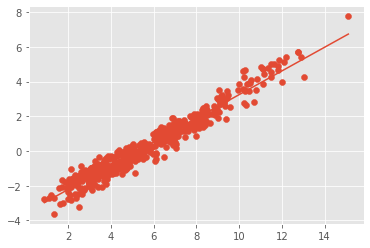

In [525]:
plt.scatter(np.log(mammals_and_birds['Body mass (g)']), np.log(mammals_and_birds['Metabolic rate (W)']))
y = np.log(mammals_and_birds['Metabolic rate (W)'])
x = np.log(mammals_and_birds['Body mass (g)'])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

### Power Statistics for All Included Species

In [524]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['Body mass (g)']), np.log(data['Metabolic rate (W)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and BMR: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and BMR: (0.6933842277255671, 0.7492695532185123)
The r^2 value for the relationship is 0.8244769319733298.
The associated p-value is 4.532672888823088e-208.


### Power Statistics for Mammals and Birds

In [526]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(mammals_and_birds['Body mass (g)']), np.log(mammals_and_birds['Metabolic rate (W)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and BMR for mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and BMR for mammals and birds: (0.6685980341931743, 0.6963995289768576)
The r^2 value for the relationship is 0.947317866293344.
The associated p-value is 0.0.


#### Binned Data to Account for Mass Skew

In [536]:
bins = np.arange(np.log(mammals_and_birds['Body mass (g)']).min(), np.log(mammals_and_birds['Body mass (g)']).max(), .25)
groupsMB = mammals_and_birds.groupby(np.digitize(np.log(mammals_and_birds['Body mass (g)']), bins))


In [537]:
slope1, intercept1, r_value, p_value, std_err1 = linregress(np.log(groupsMB['Body mass (g)'].mean()), np.log(groupsMB['Metabolic rate (W)'].mean()))
low_bound = slope1 - 1.96 * std_err1
high_bound = slope1 + 1.96 * std_err1

print('95% CI for power relationship between BM and max lifespan for mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and max lifespan for mammals and birds: (0.6922838563510229, 0.7313837410094729)
The r^2 value for the relationship is 0.9910489385017798.
The associated p-value is 9.187265025406457e-49.


### Power Statistics for Reptiles and Amphibians

In [538]:
slope2, intercept2, r_value, p_value, std_err2 = linregress(np.log(repts_and_amphibs['Body mass (g)']), np.log(repts_and_amphibs['Metabolic rate (W)']))
low_bound = slope2 - 1.96 * std_err2
high_bound = slope2 + 1.96 * std_err2

print('95% CI for power relationship between BM and max lifespan for reptiles and amphibians: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and max lifespan for reptiles and amphibians: (0.7056139986949743, 0.9063785443677932)
The r^2 value for the relationship is 0.8984273387712045.
The associated p-value is 1.954320467127725e-15.


### Significance Test in Difference in Power for Mammals and Birds versus Reptiles and Amphibians
Significant at the 0.05 significance level.

In [539]:
numerator = slope1 - slope2
denominator = pow((pow(std_err1, 2) + pow(std_err2, 2)), 1/2)
z = numerator / denominator 
norm.sf(abs(z))

0.03556473690410373

# Testing Existence of Constants in Lifetime Energy Expenditure

### Association Between Metabolic Expenditure and Lifespan

95% CI for the slope: (-0.34803137605710777, -0.2730768835862236)
The r^2 value for the relationship is 0.851510302574617.
The associated p-value is 1.1234587402081489e-20.


Text(0.5, 1.0, 'Species Metabolic Rate/Body Mass vs. Maximum Lifespan')

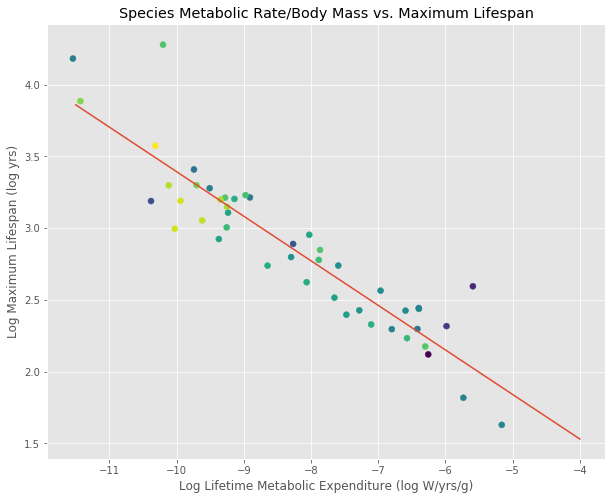

In [544]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(groupsMB['Lifetime expenditure of energy (W/yrs/g)'].mean()), np.log(groupsMB['Maximum longevity (yrs)'].mean()))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for the slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

plt.figure(figsize=(10,8))
plt.scatter(np.log(groupsMB['Lifetime expenditure of energy (W/yrs/g)'].mean()), np.log(groupsMB['Maximum longevity (yrs)'].mean()), c=groupsMB['Temperature (K)'].mean())
#plt.xlim(xmin=-.001,xmax=0.05)

xfid = np.linspace(-11.5, -4)
plt.plot(xfid, xfid*slope+intercept)

plt.xlabel('Log Lifetime Metabolic Expenditure (log W/yrs/g)')
plt.ylabel('Log Maximum Lifespan (log yrs)')
plt.title('Species Metabolic Rate/Body Mass vs. Maximum Lifespan')

Text(0.5, 1.0, 'Does Lifetime Expenditure of Energy \n Produce a Constant Across Animal Species?')

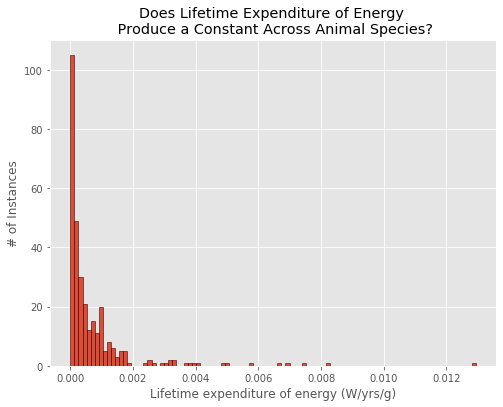

In [264]:
#temp_data = mammals_and_birds[mammals_and_birds['Lifespan Constant'] < 100000]
#Several outliers (11) exist past the 100,000 mark

plt.figure(figsize=(8,6))
plt.hist(mammals_and_birds['Lifetime expenditure of energy (W/yrs/g)'], bins=100, ec="k")
plt.xlabel('Lifetime expenditure of energy (W/yrs/g)')
plt.ylabel('# of Instances')
plt.title('Does Lifetime Expenditure of Energy \n Produce a Constant Across Animal Species?')

### Association Between Body Mass and Metabolic Expenditure

95% CI for the slope: (-0.4693779420150223, -0.4166354424068595)
The r^2 value for the relationship is 0.9592958125841132.
The associated p-value is 1.2547023420612769e-33.


Text(0.5, 1.0, 'Species Body Mass vs. Lifetime Energy Expenditure')

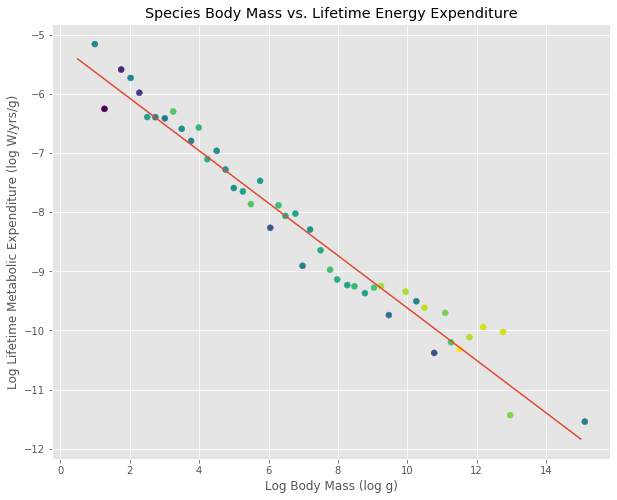

In [543]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(groupsMB['Body mass (g)'].mean()), np.log(groupsMB['Lifetime expenditure of energy (W/yrs/g)'].mean()))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for the slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

plt.figure(figsize=(10,8))
plt.scatter(np.log(groupsMB['Body mass (g)'].mean()), np.log(groupsMB['Lifetime expenditure of energy (W/yrs/g)'].mean()), c=groupsMB['Temperature (K)'].mean())
#plt.xlim(xmin=-.001,xmax=0.05)

xfid = np.linspace(0.5, 15)
plt.plot(xfid, xfid*slope+intercept)

plt.xlabel('Log Body Mass (log g)')
plt.ylabel('Log Lifetime Metabolic Expenditure (log W/yrs/g)')
plt.title('Species Body Mass vs. Lifetime Energy Expenditure')

# Temperature vs. Metabolic Rate

In [267]:
#The Asiatic elephant is an extreme outlier in terms of metabolic rate (about 2300 W)
mammals_and_birds = mammals_and_birds[mammals_and_birds['Metabolic rate (W)'] < 2000]

#The Eastern red-backed salamander is an outlier in terms of body temperature (about 5.35 C)
data = data[data['Temperature (C)'] > 10]

Text(0.5, 1.0, 'Species Internal Body Temperature vs. Metabolic Rate')

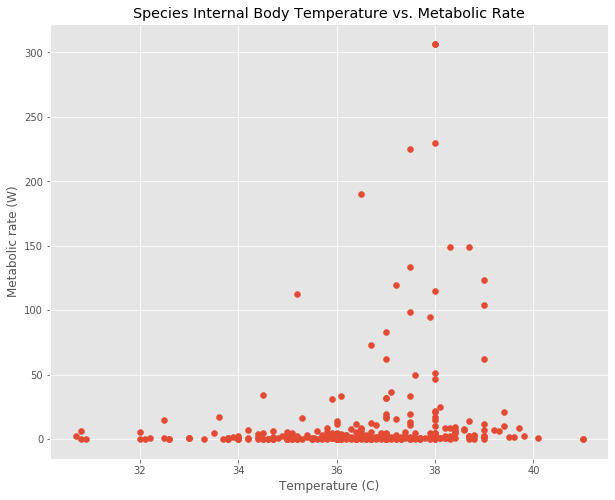

In [268]:
plt.figure(figsize=(10,8))
plt.scatter(mammals_and_birds['Temperature (C)'], mammals_and_birds['Metabolic rate (W)'])
plt.xlabel('Temperature (C)')
plt.ylabel('Metabolic rate (W)')

plt.title('Species Internal Body Temperature vs. Metabolic Rate')

In [271]:
temp_min, temp_max = np.min(1/groupsMB['Temperature (C)'].min()), np.max(1/groupsMB['Temperature (C)'].max())
BMR_min, BMR_max = np.min(groupsMB['Metabolic rate (W)'].min()), np.max(groupsMB['Metabolic rate (W)'].max())

x_sc = LinearScale(min=temp_min, max=temp_max)
y_sc = LogScale(min=BMR_min, max=BMR_max)

tt = Tooltip(fields=['x', 'y'], 
             labels=['1/Temperature (1/C)', 'Log Metabolic Rate (log W)'])

fig_scat = Scatter(x=1/groupsMB['Temperature (C)'].mean(), y=groupsMB['Metabolic rate (W)'].mean().round(decimals=2),
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=60, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='1/Temperature (1/C)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Log Metabolic Rate (log W)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Arrhenius Relationship of Temperature vs. Metabolic Rate in Mammals and Birds (Binned)')

fig

Figure(axes=[Axis(label='1/Temperature (1/C)', scale=LinearScale(max=0.029411764705882353, min=0.0263157894736…

95% CI for slope: (-3069.9776284078416, -1271.5609302013127)
The r^2 value for the relationship is 0.33723142971877534.
The associated p-value is 2.3269325462473907e-05.


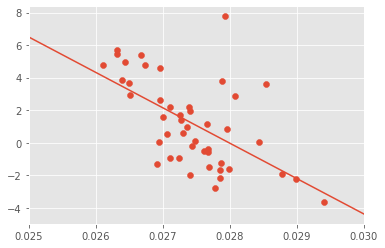

In [379]:
slope, intercept, r_value, p_value, std_err = linregress(1/groupsMB['Temperature (C)'].mean(), np.log(groupsMB['Metabolic rate (W)'].mean()))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

plt.scatter(x=1/groupsMB['Temperature (C)'].mean(), y=np.log(groupsMB['Metabolic rate (W)'].mean()))
plt.xlim(xmin=0.025, xmax=0.030)

xlin = np.linspace(0.025, 0.030, 20)
ylin = slope * xlin + intercept
plt.plot(xlin, ylin)

### Metabolic Rate vs. Lifespan

In [378]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(mammals_and_birds['Metabolic rate (W)']), np.log(mammals_and_birds['Maximum longevity (yrs)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between metabolic rate and max lifespan in mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between metabolic rate and max lifespan in mammals and birds: (0.18779075331144446, 0.254233857987815)
The r^2 value for the relationship is 0.3498237171800661.
The associated p-value is 2.1689188531408598e-31.


In [549]:
BM_min, BM_max = np.min(mammals_and_birds['Body mass (g)'].apply(np.min)), np.max(mammals_and_birds['Body mass (g)'].apply(np.max))
BMR_min, BMR_max = np.min(mammals_and_birds['Metabolic rate (W)'].apply(np.min)), np.max(mammals_and_birds['Metabolic rate (W)'].apply(np.max))
lifespan_min, lifespan_max = np.min(mammals_and_birds['Maximum longevity (yrs)'].apply(np.min)), np.max(mammals_and_birds['Maximum longevity (yrs)'].apply(np.max))

x_sc = LogScale(min=BMR_min, max=BMR_max)
y_sc = LogScale(min=lifespan_min, max=lifespan_max)
size_sc = LinearScale(min=BM_min, max=BM_max)

tt = Tooltip(fields=['name', 'x', 'y', 'size'], 
             labels=['Animal', 'Metabolic rate (W)', 'Maximum lifespan (years)', 'Body mass (g)'])

fig_scat = Scatter(x=mammals_and_birds['Metabolic rate (W)'].round(decimals = 3), y=mammals_and_birds['Maximum longevity (yrs)'], size=mammals_and_birds['Body mass (g)'],
                      names=mammals_and_birds['Common name'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'size': size_sc},
                      default_size=800, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='Metabolic Rate (W)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Maximum Lifespan (years)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y], 
             title='How Does Metabolic Rate Correlate with Maximum Lifespan \n in Mammals and Birds?')
fig.layout.height = '600px'
fig.layout.width = '800px'

fig

Figure(axes=[Axis(label='Metabolic Rate (W)', scale=LogScale(max=2336.5, min=0.027000000000000003)), Axis(labe…

95% CI for slope: (-1.5157136793702954, -0.9860415347026216)
The r^2 value for the relationship is 0.6607590375417849.
The associated p-value is 6.826252521963855e-12.


Text(0, 0.5, 'Maximum Lifespan (yrs)')

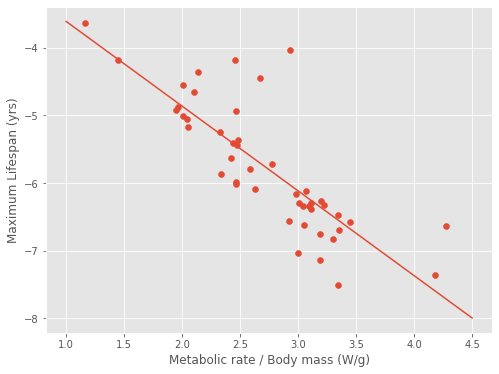

In [376]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(groupsMB['Maximum longevity (yrs)'].mean()), np.log(groupsMB['Metabolic rate (W)'].mean()/groupsMB['Body mass (g)'].mean()))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')


plt.figure(figsize=(8,6))
plt.scatter(np.log(groupsMB['Maximum longevity (yrs)'].mean()), np.log(groupsMB['Metabolic rate (W)'].mean()/groupsMB['Body mass (g)'].mean()))

xlin = np.linspace(1, 4.5, 10)
ylin = slope * xlin + intercept
plt.plot(xlin, ylin)

plt.xlabel('Metabolic rate / Body mass (W/g)')
plt.ylabel('Maximum Lifespan (yrs)')
